In [95]:
import pandas as pd
import seaborn as sns
import numpy as np
#from datetime import datetime
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.style.use('seaborn-darkgrid')
from scipy import stats
import math
import os
from dateutil.parser import parse
from datetime import datetime, date, time
import calendar
from datetime import timedelta

In [6]:
#Data loading
dataset2 = pd.read_excel(open('Online Retail.xlsx','rb'), sheet_name='Online Retail')


In [7]:
#Downsampling if needed
dataset = dataset2#[:5000]
dataset.shape

(541909, 8)

In [8]:
#We sort the dataset and check the time range
dataset = dataset.sort_values('InvoiceDate')
print('First order', dataset['InvoiceDate'].min())
print('Last order', dataset['InvoiceDate'].max())

First order 2010-12-01 08:26:00
Last order 2011-12-09 12:50:00


In [9]:
#We mark the cancelled invoices
dataset['Cancelled'] = dataset['InvoiceNo'].apply(lambda x: 1 if str(x).startswith('C') else 0)
dataset[dataset['Cancelled'] == 1].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,1
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,1
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom,1
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,1


In [10]:
#We keep only the info from UK
dataset = dataset[dataset['Country'] == 'United Kingdom']
dataset.shape

(495478, 9)

In [11]:
#We drop the duplicates
dataset = dataset.drop_duplicates()
dataset.shape

(490300, 9)

In [12]:
#We drop the fields with no customer ID
dataset = dataset.dropna(axis = 0, how = 'any', subset = ['CustomerID'])
dataset.shape

(356728, 9)

In [13]:
#Any odd values ?
dataset.describe()

,Quantity,UnitPrice,CustomerID,Cancelled
count,356728.000000,356728.000000,356728.000000,356728.000000
mean,11.198644,3.268255,15543.795284,0.021027
std,264.998044,71.162330,1594.286219,0.143475
min,-80995.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,14191.000000,0.000000
50%,4.000000,1.950000,15513.000000,0.000000
75%,12.000000,3.750000,16931.000000,0.000000
max,80995.000000,38970.000000,18287.000000,1.000000


In [14]:
#We clean all the weird Stockcodes

#drop all the that are extra fees
extrafeereasons = ['POST', 'DOT', 'C2', 'CRUK', 'M', 'BANK CHARGES', 'PADS', 'D']
for todrop in extrafeereasons:
    dataset = dataset[dataset['StockCode'] != todrop]
dataset.shape


(356110, 9)

In [15]:
dataset = dataset[dataset['UnitPrice'] != 0.00]
dataset.shape

(356090, 9)

In [16]:
#We clean the quantity < 0 and invoice not cancelled
#dataset = 
dataset[(dataset['Quantity'] < 0) & (dataset['Cancelled'] == 0)]
#dataset.shape

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled


In [17]:
#No free stuff in the dataset, must cost at least 1 penny
dataset = dataset[dataset['UnitPrice'] >= 0.01]
dataset.shape

(356090, 9)

In [18]:
#Any np.nan remaining ?
dataset.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Cancelled      0
dtype: int64

In [19]:
#Totat per item
dataset['TotalItem'] = dataset['UnitPrice'] * dataset['Quantity']
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34


In [20]:
#initial price calculation
initpricedict = dataset[['UnitPrice', 'StockCode']].groupby('StockCode')['UnitPrice'].first().to_dict()
dataset['Initprice'] = dataset['StockCode'].apply(lambda x : initpricedict[x])
dataset['ItemDiscount'] = dataset['Initprice'] / dataset['UnitPrice']
dataset['TotalItemInit'] = dataset['Initprice'] * dataset['Quantity']
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,Initprice,ItemDiscount,TotalItemInit
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2.55,1.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2.75,1.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34


In [21]:
#Savings calculation
dataset['Savings'] = dataset['TotalItem'] - dataset['TotalItemInit']
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,Initprice,ItemDiscount,TotalItemInit,Savings
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2.55,1.0,15.30,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2.75,1.0,22.00,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0


In [22]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,Initprice,ItemDiscount,TotalItemInit,Savings
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2.55,1.0,15.30,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2.75,1.0,22.00,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0


In [23]:
#We split the unit prices by quantile
classes = 5

#### CALULATION BEGINNING ####
divider = 100/classes

price = dataset[['StockCode', 'UnitPrice']].groupby('StockCode').first()

price['QuantUnitPrice'] = price['UnitPrice'].apply(lambda x: math.ceil(stats.percentileofscore(price['UnitPrice'],x, kind = 'mean')/divider))
price[['UnitPrice', 'QuantUnitPrice']].head()


pricedictquant = price['QuantUnitPrice'].to_dict()

dataset['QuantUnitPrice'] = dataset['StockCode'].apply(lambda x: pricedictquant.get(x, 0))

dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,Initprice,ItemDiscount,TotalItemInit,Savings,QuantUnitPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2.55,1.0,15.30,0.0,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2.75,1.0,22.00,0.0,4
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4


In [24]:
#quant unit price vectorization - dollars

temp = dataset.pivot(columns='QuantUnitPrice', values='TotalItem').fillna(0)
new_names = [(i, 'QuantUnitPrice_{:02d}'.format(i)) for i in temp.columns.values]
temp.rename(columns = dict(new_names), inplace=True)
temp.head()
dataset = dataset.merge(temp, how='inner', left_index=True, right_index=True)
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,Initprice,ItemDiscount,TotalItemInit,Savings,QuantUnitPrice,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2.55,1.0,15.30,0.0,3,0.0,0.0,15.3,0.00,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4,0.0,0.0,0.0,20.34,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2.75,1.0,22.00,0.0,4,0.0,0.0,0.0,22.00,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4,0.0,0.0,0.0,20.34,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,3.39,1.0,20.34,0.0,4,0.0,0.0,0.0,20.34,0.0


In [25]:
#quant unit price savings vectorization - savings

temp = dataset.pivot(columns='QuantUnitPrice', values='Savings').fillna(0)
new_names = [(i, 'QuantUnitSavings_{:02d}'.format(i)) for i in temp.columns.values]
temp.rename(columns = dict(new_names), inplace=True)
temp.head()
dataset = dataset.merge(temp, how='inner', left_index=True, right_index=True)
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,...,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05,QuantUnitSavings_01,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,...,0.0,0.0,15.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,...,0.0,0.0,0.0,22.00,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#Amount cancelled
dataset['AmountCancelled'] = dataset['Cancelled'] * dataset['TotalItem']

dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalItem,...,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05,QuantUnitSavings_01,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05,AmountCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,...,0.0,15.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,...,0.0,0.0,22.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,...,0.0,0.0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
dataset.columns.values

array(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Cancelled', 'TotalItem',
       'Initprice', 'ItemDiscount', 'TotalItemInit', 'Savings',
       'QuantUnitPrice', 'QuantUnitPrice_01', 'QuantUnitPrice_02',
       'QuantUnitPrice_03', 'QuantUnitPrice_04', 'QuantUnitPrice_05',
       'QuantUnitSavings_01', 'QuantUnitSavings_02', 'QuantUnitSavings_03',
       'QuantUnitSavings_04', 'QuantUnitSavings_05', 'AmountCancelled'], dtype=object)

In [28]:
#Invoicedb calculation

def my_agg(x):
    aggcalcul = {
        'InvoiceDate': x['InvoiceDate'].min(),
        'TotalInvoice': x['TotalItem'].sum(),
        'TotalInvoiceInit': x['TotalItemInit'].sum(),
        'CustomerID':  x['CustomerID'].min(),
        'TotalSavings': x['Savings'].sum(),
        'AmountCancelled' : x['AmountCancelled'].sum(),
        }
    return pd.Series(aggcalcul, index=aggcalcul.keys())
invoicedb = dataset.groupby('InvoiceNo').apply(my_agg).fillna(0)

invoicedb.head()


,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled
InvoiceNo,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0


In [29]:
#detail orders for invoicedb - QUANT UNIT PRICE
detail = [x for x in dataset.columns.values if x.startswith('QuantUnitPrice_')]
detail.append('InvoiceNo')
temp = dataset[detail].groupby('InvoiceNo').sum()
temp.head()
invoicedb = invoicedb.merge(temp, how='inner', left_index=True, right_index=True)
invoicedb.head()

,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05
InvoiceNo,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,15.30
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,0.00
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,134.05
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,44.55
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,17.85


In [30]:
#detail orders for invoicedb - QUANT UNIT SAVINGS
detail = [x for x in dataset.columns.values if x.startswith('QuantUnitSavings_')]
detail.append('InvoiceNo')
temp = dataset[detail].groupby('InvoiceNo').sum()
temp.head()
invoicedb = invoicedb.merge(temp, how='inner', left_index=True, right_index=True)
invoicedb.head()

,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05,QuantUnitSavings_01,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05
InvoiceNo,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,15.30,0.0,0.0,0.0,0.0,0.0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,0.00,0.0,0.0,0.0,0.0,0.0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,134.05,0.0,0.0,0.0,0.0,0.0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,44.55,0.0,0.0,0.0,0.0,0.0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,17.85,0.0,0.0,0.0,0.0,0.0


In [31]:
#Invoicedb updates

#Day between orders calculation
invoicedb = invoicedb.sort_values('InvoiceDate')
invoicedb['Ordersep'] = invoicedb[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).InvoiceDate.apply(lambda x: x.diff()).fillna(0)
invoicedb['Ordersep'] = invoicedb['Ordersep'].apply(lambda x: x.days)
invoicedb.head()

,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05,QuantUnitSavings_01,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05,Ordersep
InvoiceNo,,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,15.30,0.0,0.0,0.0,0.0,0.0,0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,134.05,0.0,0.0,0.0,0.0,0.0,0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,44.55,0.0,0.0,0.0,0.0,0.0,0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,17.85,0.0,0.0,0.0,0.0,0.0,0


In [32]:
#InvoiceDB discount
invoicedb['Discount'] = invoicedb['TotalInvoice'] / invoicedb['TotalInvoiceInit']
invoicedb.head()

,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,QuantUnitPrice_05,QuantUnitSavings_01,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05,Ordersep,Discount
InvoiceNo,,,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,15.30,0.0,0.0,0.0,0.0,0.0,0,1.0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,1.0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,134.05,0.0,0.0,0.0,0.0,0.0,0,1.0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,44.55,0.0,0.0,0.0,0.0,0.0,0,1.0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,17.85,0.0,0.0,0.0,0.0,0.0,0,1.0


In [33]:
#When the order has been placed during the day in pounds?

def daysplit(x):
    hour = x.hour
    if 6 < hour < 12:
        return 1
    elif 12 <= hour < 20:
        return 2
    else:
        return 3

invoicedb['Daytime'] = invoicedb['InvoiceDate'].apply(daysplit)
    
temp = invoicedb.pivot(columns='Daytime', values='TotalInvoice').fillna(0)
new_names = [(i, 'Daytime_Monetary_'+str(i)) for i in temp.columns.values]
temp.rename(columns = dict(new_names), inplace=True)
#temp = pd.get_dummies(invoicedb['InvoiceDate'].map(daysplit), prefix = 'Daytime')
invoicedb = invoicedb.merge(temp, how='inner', left_index=True, right_index=True)
invoicedb.head()

,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,...,QuantUnitSavings_02,QuantUnitSavings_03,QuantUnitSavings_04,QuantUnitSavings_05,Ordersep,Discount,Daytime,Daytime_Monetary_1,Daytime_Monetary_2,Daytime_Monetary_3
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,...,0.0,0.0,0.0,0.0,0,1.0,1,139.12,0.0,0.0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,...,0.0,0.0,0.0,0.0,0,1.0,1,22.20,0.0,0.0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,...,0.0,0.0,0.0,0.0,0,1.0,1,278.73,0.0,0.0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,...,0.0,0.0,0.0,0.0,0,1.0,1,70.05,0.0,0.0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0,1.0,1,17.85,0.0,0.0


In [34]:
#When the order has been placed during the week in pounds?
def daysplit(x):
    day = x.weekday()
    return 'Weekday_{}_{}'.format(day, list(calendar.day_name)[day])
    #return day

invoicedb['Weekday'] = invoicedb['InvoiceDate'].map(daysplit)
temp = invoicedb.pivot(columns='Weekday', values='TotalInvoice').fillna(0)
#temp.head()
invoicedb = invoicedb.merge(temp, how='inner', left_index=True, right_index=True)
invoicedb.head()



,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,...,Daytime_Monetary_1,Daytime_Monetary_2,Daytime_Monetary_3,Weekday,Weekday_0_Monday,Weekday_1_Tuesday,Weekday_2_Wednesday,Weekday_3_Thursday,Weekday_4_Friday,Weekday_6_Sunday
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,...,139.12,0.0,0.0,Weekday_2_Wednesday,0.0,0.0,139.12,0.0,0.0,0.0
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,...,22.20,0.0,0.0,Weekday_2_Wednesday,0.0,0.0,22.20,0.0,0.0,0.0
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,...,278.73,0.0,0.0,Weekday_2_Wednesday,0.0,0.0,278.73,0.0,0.0,0.0
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,...,70.05,0.0,0.0,Weekday_2_Wednesday,0.0,0.0,70.05,0.0,0.0,0.0
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,...,17.85,0.0,0.0,Weekday_2_Wednesday,0.0,0.0,17.85,0.0,0.0,0.0


In [35]:
#When the order has been placed during the month?
def daysplit(x):
    month = x.month
    return 'Month_{:02d}'.format(month)
    #return day

invoicedb['MonthOrder'] = invoicedb['InvoiceDate'].apply(daysplit)    
temp = invoicedb.pivot(columns='MonthOrder', values='TotalInvoice').fillna(0)   
#temp = pd.get_dummies(invoicedb['InvoiceDate'].map(daysplit))
#temp.head()
invoicedb = invoicedb.merge(temp, how='inner', left_index=True, right_index=True)
invoicedb.head()


,InvoiceDate,TotalInvoice,TotalInvoiceInit,CustomerID,TotalSavings,AmountCancelled,QuantUnitPrice_01,QuantUnitPrice_02,QuantUnitPrice_03,QuantUnitPrice_04,...,Month_03,Month_04,Month_05,Month_06,Month_07,Month_08,Month_09,Month_10,Month_11,Month_12
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,2010-12-01 08:26:00,139.12,139.12,17850.0,0.0,0.0,0.0,0.0,15.30,108.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139.12
536366,2010-12-01 08:28:00,22.20,22.20,17850.0,0.0,0.0,0.0,0.0,22.20,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.20
536367,2010-12-01 08:34:00,278.73,278.73,13047.0,0.0,0.0,0.0,0.0,89.18,55.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,278.73
536368,2010-12-01 08:34:00,70.05,70.05,13047.0,0.0,0.0,0.0,0.0,0.00,25.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.05
536369,2010-12-01 08:35:00,17.85,17.85,13047.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.85


In [36]:
#Invoicedb trimming to 1 exact year
print('### BEFORE ###')
print('Min date -->', invoicedb['InvoiceDate'].min())
print('Max date -->', invoicedb['InvoiceDate'].max())
invoicedb = invoicedb[invoicedb['InvoiceDate'] <= datetime(2011,12,1,0,0)]
print('### AFTER ###')
print('Min date -->', invoicedb['InvoiceDate'].min())
print('Max date -->', invoicedb['InvoiceDate'].max())

### BEFORE ###
Min date --> 2010-12-01 08:26:00
Max date --> 2011-12-09 12:49:00
### AFTER ###
Min date --> 2010-12-01 08:26:00
Max date --> 2011-11-30 17:42:00


In [37]:
invoicedb.shape

(18758, 42)

In [40]:
#To get the nice sterling pound character
pound = u'\u00A3'

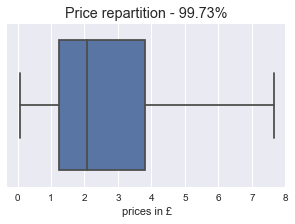

,UnitPrice
count,3653.000000
mean,3.558040
std,8.482546
min,0.070000
25%,1.250000
50%,2.080000
75%,3.810000
max,295.000000


In [119]:
#What are the prices in the dataset
df = dataset[['UnitPrice', 'StockCode']].groupby('StockCode').first()
#df.plot(kind = 'box', sym = '')
fig, ax = plt.subplots(figsize=(5, 3))
ax = sns.boxplot(x = df['UnitPrice'], sym = '')
plt.title('Price repartition - 99.73%', fontsize = 'large')
plt.xlabel('prices in {}'.format(pound))
plt.ylabel('')
plt.show()
df.describe()

In [46]:
#What is the most expensive item ?
dataset[dataset['UnitPrice'] == 295]
df = dataset[dataset['StockCode'] == 22655]
df.UnitPrice.mean()

152.45348837209303

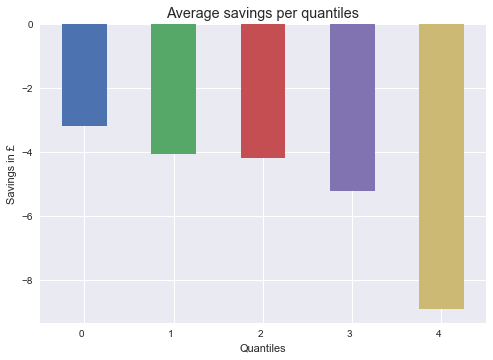

In [118]:
#Is the store offering discounts based on prices

QuantUnitSavings = [x for x in dataset.columns.values if x.startswith('QuantUnitSavings')]
df = invoicedb[QuantUnitSavings].mean()
ax = df.plot(kind='bar')
plt.title('Average savings per quantiles', fontsize = 'large')
plt.ylabel('Savings in {}'.format(pound))
plt.xlabel('Quantiles')
plt.setp(ax.get_xticklabels(), rotation = 0, ha = 'right')

a=ax.get_xticks().tolist()
#a[1]='change'
ax.set_xticklabels(a)

plt.show()




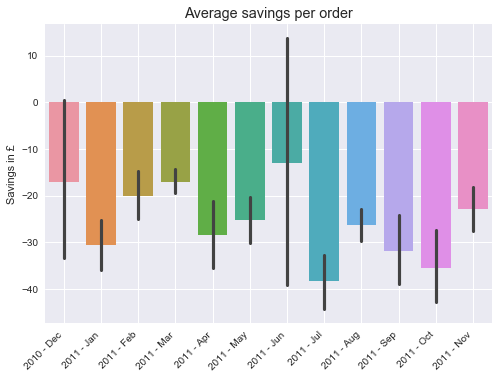

In [120]:
#which month is more likely to offer discounts?
invoicedb['InvoiceMonth'] = invoicedb['InvoiceDate'].apply(lambda x: x.strftime('%Y - %b'))
ax = sns.barplot(x="InvoiceMonth", y="TotalSavings", data=invoicedb, estimator = np.mean, ci=68)
#sns.barplot(x="InvoiceMonth", y="TotalSavings", data=invoicedb, estimator = np.sum)
plt.title('Average savings per order', fontsize = 'large')
plt.ylabel('Savings in {}'.format(pound))
plt.xlabel('')
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
ax.grid(color='white', linestyle='-', linewidth=1, axis = 'x')
plt.show()

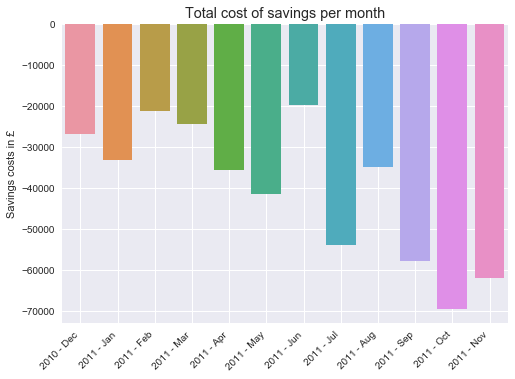

In [121]:
#What is the cost of discounts per month?
invoicedb['InvoiceMonth'] = invoicedb['InvoiceDate'].apply(lambda x: x.strftime('%Y - %b'))
#ax = sns.barplot(x="InvoiceMonth", y="TotalSavings", data=invoicedb, estimator = np.mean, ci=68)
ax = sns.barplot(x="InvoiceMonth", y="TotalSavings", data=invoicedb, estimator = np.sum, ci=None)
plt.title('Total cost of savings per month', fontsize = 'large')
plt.ylabel('Savings costs in {}'.format(pound))
plt.xlabel('')
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
ax.grid(color='white', linestyle='-', linewidth=1, axis = 'x')
plt.show()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

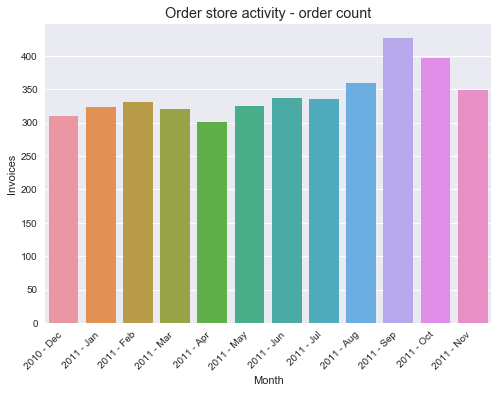

In [131]:
#store activity per months
invoicedb['InvoiceMonth'] = invoicedb['InvoiceDate'].apply(lambda x: x.strftime('%Y - %b'))
ax = sns.barplot(x="InvoiceMonth", y="TotalInvoice", data=invoicedb, estimator = np.mean, ci = None)
plt.title('Order store activity - order count', fontsize = 'large')
plt.ylabel('Invoices')
plt.xlabel('Month')
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')

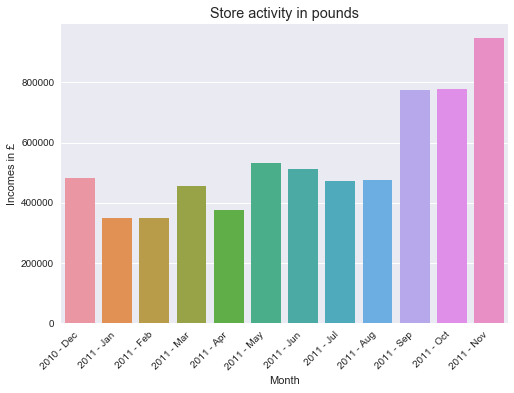

In [138]:
#store activity per months in pounds
invoicedb['InvoiceMonth'] = invoicedb['InvoiceDate'].apply(lambda x: x.strftime('%Y - %b'))
ax = sns.barplot(x="InvoiceMonth", y="TotalInvoice", data=invoicedb, estimator = np.sum, ci = None)
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
plt.xlabel('Month')
plt.ylabel('Incomes in {}'.format(pound))
plt.title('Store activity in pounds', fontsize = 'large')
plt.show()

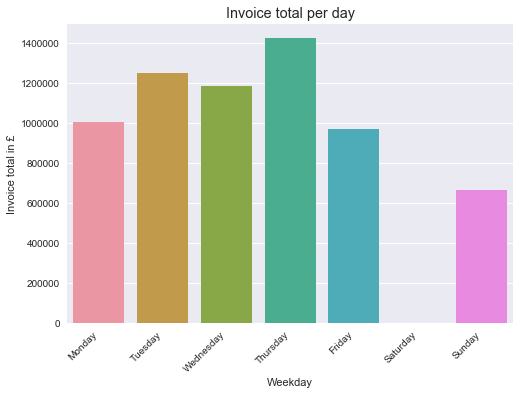

In [156]:
#store activity per weeks in pounds
invoicedb['Weekday'] = invoicedb['InvoiceDate'].apply(lambda x: x.strftime('%A'))
dayorder = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.barplot(x="Weekday", y="TotalInvoice", data=invoicedb, estimator = np.sum, ci = None, order = dayorder)
plt.ylabel('Invoice total in {}'.format(pound))
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
#ax.grid(color='grey', linestyle='--', linewidth=1, axis = 'y')
plt.xlabel('Weekday')
plt.title('Invoice total per day', fontsize = 'large')
plt.show()

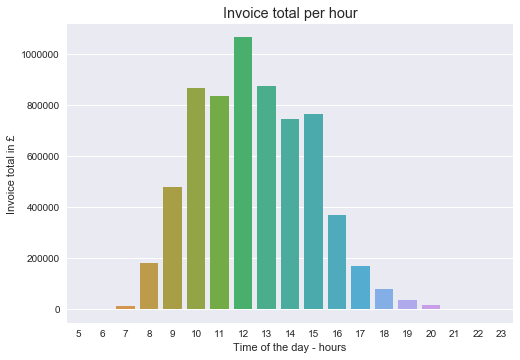

In [157]:
#store activity per time of the day
invoicedb['invoicehour'] = invoicedb['InvoiceDate'].apply(lambda x: x.hour)
hourorder = range(5,24)
ax = sns.barplot(x="invoicehour", y="TotalInvoice", data=invoicedb, estimator = np.sum, ci = None, order = hourorder)
plt.ylabel('Invoice total in {}'.format(pound))
#plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
#ax.grid(color='grey', linestyle='--', linewidth=1, axis = 'y')
plt.xlabel('Time of the day - hours')
plt.title('Invoice total per hour', fontsize = 'large')
plt.show()

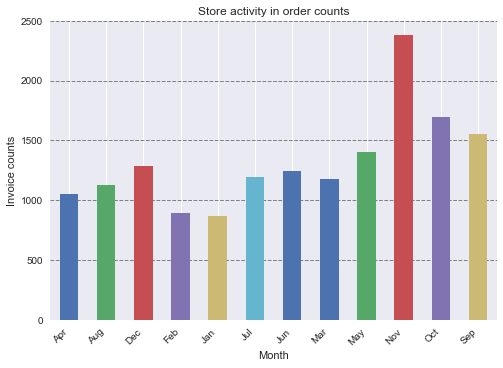

In [158]:
#number of shipment per month
df = invoicedb[invoicedb['AmountCancelled']==0]
df = df.reset_index()
df = df.groupby('MonthOrder').count()
ax = df['InvoiceNo'].plot(kind = 'bar')
plt.ylabel('Invoice counts')
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
ax.legend().set_visible(False)
ax.grid(color='grey', linestyle='--', linewidth=1, axis = 'y')
plt.xlabel('Month')
plt.title('Store activity in order counts')
plt.show()

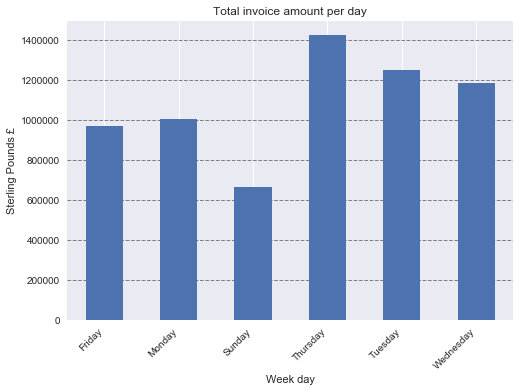

In [159]:
#What is the histogram of spendigs per day in the week
#invoicedb['InvoiceWeekDay'] = invoicedb['InvoiceDate'].apply(lambda x: x.weekday())
df = invoicedb[['Weekday', 'TotalInvoice']].groupby('Weekday').sum()
ax = df.plot(kind = 'bar')
plt.ylabel('Sterling Pounds '+ u'\u00A3')
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
ax.legend().set_visible(False)
ax.grid(color='grey', linestyle='--', linewidth=1, axis = 'y')
plt.xlabel('Week day')
plt.title('Total invoice amount per day')
plt.show()

In [183]:
#What should be the time covered for the machine learning
invoicedb[['Ordersep']].describe()

,Ordersep
count,18758.000000
mean,26.373227
std,45.427731
min,0.000000
25%,0.000000
50%,7.000000
75%,33.000000
max,364.000000


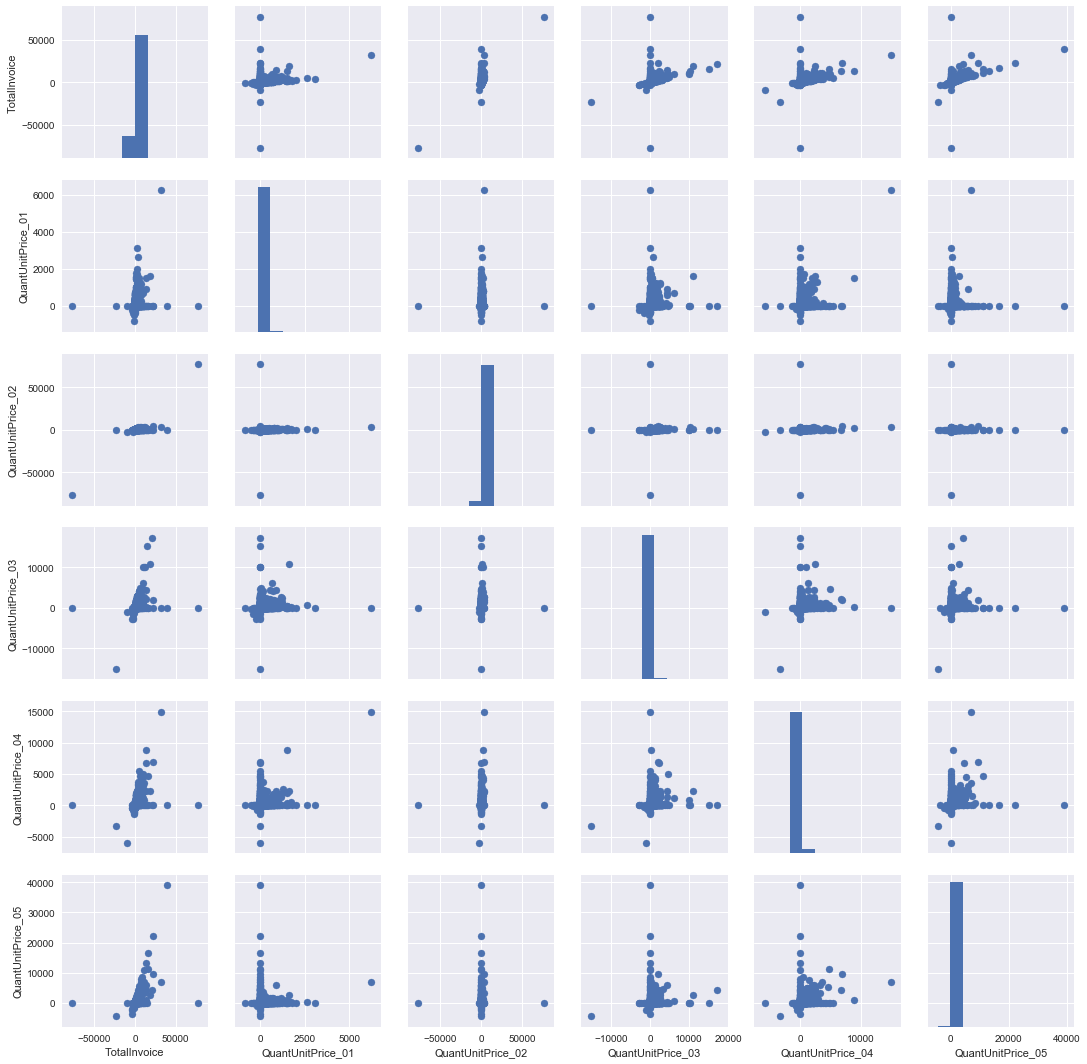

In [186]:
g = sns.PairGrid(invoicedb[['TotalInvoice', 'QuantUnitPrice_01', 'QuantUnitPrice_02', 'QuantUnitPrice_03', 'QuantUnitPrice_04', 'QuantUnitPrice_05']])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

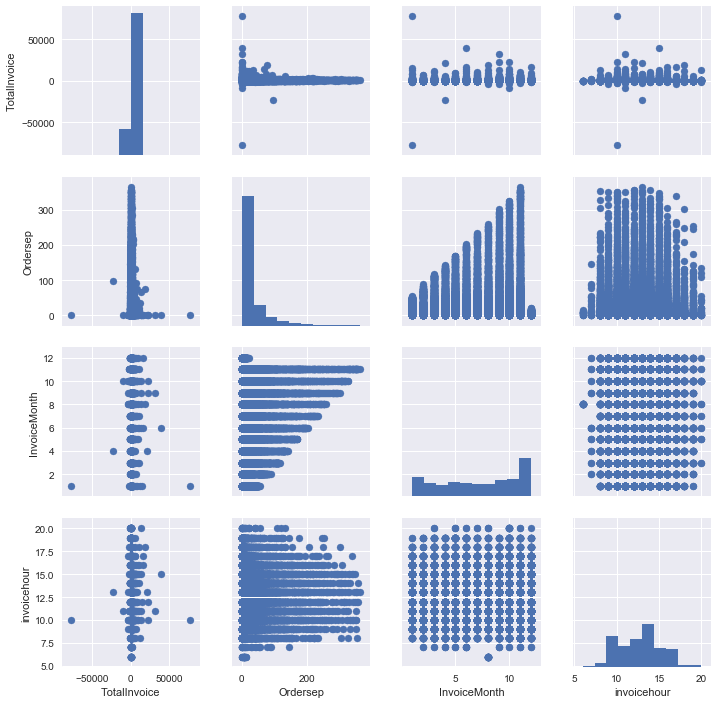

In [189]:
invoicedb['InvoiceMonth'] = invoicedb['InvoiceDate'].apply(lambda x: x.month)
g = sns.PairGrid(invoicedb[['TotalInvoice', 'Ordersep', 'InvoiceMonth', 'invoicehour']])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

In [187]:
invoicedb.columns.values


array(['InvoiceDate', 'TotalInvoice', 'TotalInvoiceInit', 'CustomerID',
       'TotalSavings', 'AmountCancelled', 'QuantUnitPrice_01',
       'QuantUnitPrice_02', 'QuantUnitPrice_03', 'QuantUnitPrice_04',
       'QuantUnitPrice_05', 'QuantUnitSavings_01', 'QuantUnitSavings_02',
       'QuantUnitSavings_03', 'QuantUnitSavings_04', 'QuantUnitSavings_05',
       'Ordersep', 'Discount', 'Daytime', 'Daytime_Monetary_1',
       'Daytime_Monetary_2', 'Daytime_Monetary_3', 'Weekday',
       'Weekday_0_Monday', 'Weekday_1_Tuesday', 'Weekday_2_Wednesday',
       'Weekday_3_Thursday', 'Weekday_4_Friday', 'Weekday_6_Sunday',
       'MonthOrder', 'Month_01', 'Month_02', 'Month_03', 'Month_04',
       'Month_05', 'Month_06', 'Month_07', 'Month_08', 'Month_09',
       'Month_10', 'Month_11', 'Month_12', 'InvoiceMonth', 'invoicehour'], dtype=object)

In [161]:
#Customerdb creation
date = invoicedb['InvoiceDate'].max()
def my_agg(x):
    aggcalcul = {
        'LastInvoice': x['InvoiceDate'].max(),
        'Recency': (date - x['InvoiceDate'].max()).days,
        'SpentMin': x['TotalInvoice'].min(),
        'SpentMax': x['TotalInvoice'].max(),
        'SpentMean': x['TotalInvoice'].mean(),
        'SpentSum': x['TotalInvoice'].sum(),
        'SpentStd': x['TotalInvoice'].std(),
        'OrderSepMean': x['Ordersep'].mean(),
        'OrderSepMax' : x['Ordersep'].max(),
        'OrderSepMin' : x['Ordersep'].min(),
        'OrderSepStd' : x['Ordersep'].std(),
        'Frequency' : x['InvoiceDate'].count(),
        'DiscountMean' : x['Discount'].mean(),
        'DiscountMax' : x['Discount'].max(),
        'DiscountMin' : x['Discount'].min(),
        'DiscountStd' : x['Discount'].std(),
        'SavingsSum' : x['TotalSavings'].sum(),
        'SavingsMean' : x['TotalSavings'].mean(),
        'SavingsMax' : x['TotalSavings'].max(),
        'SavingsMin' :x['TotalSavings'].min(), 
        'SavingsStd' : x['TotalSavings'].std(),
        'AmountCancelledSum' : x['AmountCancelled'].sum(),
        'AmountCancelledMean' : x['AmountCancelled'].mean(),
        'AmountCancelledMin' : x['AmountCancelled'].min(),
        'AmountCancelledMax' : x['AmountCancelled'].max(),
        'AmountCancelledStd' : x['AmountCancelled'].std(),
        }
    return pd.Series(aggcalcul, index=aggcalcul.keys())
customerdb = invoicedb.groupby('CustomerID').apply(my_agg).fillna(0)

customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,SavingsSum,SavingsMean,SavingsMax,SavingsMin,SavingsStd,AmountCancelledSum,AmountCancelledMean,AmountCancelledMin,AmountCancelledMax,AmountCancelledStd
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,316,-77183.60,77183.60,0.000000,0.00,109154.093913,0.000000,0,0,...,0.00,0.000000,0.00,0.00,0.000000,-77183.60,-38591.800000,-77183.60,0.0,54577.046956
12747.0,2011-11-17 17:13:00,13,301.70,675.38,375.751000,3757.51,113.816074,34.400000,65,0,...,55.52,5.552000,40.20,-32.40,24.156115,0.00,0.000000,0.00,0.0,0.000000
12748.0,2011-11-29 18:19:00,0,-1301.00,1948.35,138.566538,28821.84,260.037327,1.408654,30,0,...,-11806.47,-56.761875,4452.50,-7780.50,702.918396,-1830.79,-8.801875,-1301.00,0.0,91.756623
12749.0,2011-11-17 12:05:00,13,-125.78,1866.43,436.448571,3055.14,728.506495,26.857143,91,0,...,95.37,13.624286,41.64,-3.29,20.310731,-222.68,-31.811429,-125.78,0.0,50.102976
12820.0,2011-10-26 13:27:00,35,170.46,343.76,243.996667,731.99,89.577347,93.666667,251,0,...,10.88,3.626667,4.80,1.68,1.697685,0.00,0.000000,0.00,0.0,0.000000


In [162]:
#detail orders for customerdb QUANT UNIT PRICE
detail = [x for x in invoicedb.columns.values if x.startswith('QuantUnitPrice_')]
detail.append('CustomerID')
temp = invoicedb[detail].groupby('CustomerID').agg([np.sum, np.mean, np.min, np.max, np.std]).fillna(0)
newnames = ["_".join(x) for x in temp.columns.ravel()]
temp.columns = newnames
temp.head()
customerdb = customerdb.merge(temp, how='inner', left_index=True, right_index=True)
customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,QuantUnitPrice_04_sum,QuantUnitPrice_04_mean,QuantUnitPrice_04_amin,QuantUnitPrice_04_amax,QuantUnitPrice_04_std,QuantUnitPrice_05_sum,QuantUnitPrice_05_mean,QuantUnitPrice_05_amin,QuantUnitPrice_05_amax,QuantUnitPrice_05_std
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,316,-77183.60,77183.60,0.000000,0.00,109154.093913,0.000000,0,0,...,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000
12747.0,2011-11-17 17:13:00,13,301.70,675.38,375.751000,3757.51,113.816074,34.400000,65,0,...,77.00,7.700000,0.00,17.00,8.138386,2030.75,203.075000,55.70,308.10,73.246654
12748.0,2011-11-29 18:19:00,0,-1301.00,1948.35,138.566538,28821.84,260.037327,1.408654,30,0,...,6050.58,29.089327,-485.00,550.00,77.076684,6824.41,32.809663,-816.00,816.00,110.385568
12749.0,2011-11-17 12:05:00,13,-125.78,1866.43,436.448571,3055.14,728.506495,26.857143,91,0,...,730.79,104.398571,-30.22,372.06,159.439473,1337.75,191.107143,-70.35,832.25,325.412730
12820.0,2011-10-26 13:27:00,35,170.46,343.76,243.996667,731.99,89.577347,93.666667,251,0,...,130.64,43.546667,17.70,73.04,27.849642,44.55,14.850000,0.00,24.75,13.096469


In [163]:
#detail orders for customerdb QUANT SAVINGS
detail = [x for x in invoicedb.columns.values if x.startswith('QuantUnitSavings_')]
detail.append('CustomerID')
temp = invoicedb[detail].groupby('CustomerID').agg([np.sum, np.mean, np.min, np.max, np.std]).fillna(0)
newnames = ["_".join(x) for x in temp.columns.ravel()]
temp.columns = newnames
temp.head()
customerdb = customerdb.merge(temp, how='inner', left_index=True, right_index=True)
customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,QuantUnitSavings_04_sum,QuantUnitSavings_04_mean,QuantUnitSavings_04_amin,QuantUnitSavings_04_amax,QuantUnitSavings_04_std,QuantUnitSavings_05_sum,QuantUnitSavings_05_mean,QuantUnitSavings_05_amin,QuantUnitSavings_05_amax,QuantUnitSavings_05_std
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,316,-77183.60,77183.60,0.000000,0.00,109154.093913,0.000000,0,0,...,0.00,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.000000
12747.0,2011-11-17 17:13:00,13,301.70,675.38,375.751000,3757.51,113.816074,34.400000,65,0,...,0.00,0.000000,0.0,0.0,0.000000,-33.50,-3.350000,-32.4,12.3,18.486707
12748.0,2011-11-29 18:19:00,0,-1301.00,1948.35,138.566538,28821.84,260.037327,1.408654,30,0,...,-5372.11,-25.827452,-4125.0,2023.1,351.510717,-3831.82,-18.422212,-3588.0,2429.4,344.981809
12749.0,2011-11-17 12:05:00,13,-125.78,1866.43,436.448571,3055.14,728.506495,26.857143,91,0,...,16.40,2.342857,-0.8,7.4,3.434558,52.40,7.485714,-2.0,30.8,12.452500
12820.0,2011-10-26 13:27:00,35,170.46,343.76,243.996667,731.99,89.577347,93.666667,251,0,...,0.00,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.000000


In [164]:
#Time of the day aggregation
detail = [x for x in invoicedb.columns.values if x.startswith('Daytime_Monetary_')]
detail.append('CustomerID')
temp = invoicedb[detail].groupby('CustomerID').agg([np.sum, np.mean, np.std]).fillna(0)
newnames = ["_".join(x) for x in temp.columns.ravel()]
#temp.columns = temp.columns.droplevel(0)
temp.columns = newnames
temp.head()
customerdb = customerdb.merge(temp, how='inner', left_index=True, right_index=True)
customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,QuantUnitSavings_05_std,Daytime_Monetary_1_sum,Daytime_Monetary_1_mean,Daytime_Monetary_1_std,Daytime_Monetary_2_sum,Daytime_Monetary_2_mean,Daytime_Monetary_2_std,Daytime_Monetary_3_sum,Daytime_Monetary_3_mean,Daytime_Monetary_3_std
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,316,-77183.60,77183.60,0.000000,0.00,109154.093913,0.000000,0,0,...,0.000000,0.00,0.000000,109154.093913,0.00,0.000000,0.000000,0.00,0.000000,0.000000
12747.0,2011-11-17 17:13:00,13,301.70,675.38,375.751000,3757.51,113.816074,34.400000,65,0,...,18.486707,2029.44,202.944000,237.022273,1728.07,172.807000,186.301353,0.00,0.000000,0.000000
12748.0,2011-11-29 18:19:00,0,-1301.00,1948.35,138.566538,28821.84,260.037327,1.408654,30,0,...,344.981809,4571.33,21.977548,70.641579,24231.32,116.496731,260.381346,19.19,0.092260,1.330587
12749.0,2011-11-17 12:05:00,13,-125.78,1866.43,436.448571,3055.14,728.506495,26.857143,91,0,...,12.452500,-125.78,-17.968571,47.540371,3200.82,457.260000,711.561452,-19.90,-2.842857,7.521493
12820.0,2011-10-26 13:27:00,35,170.46,343.76,243.996667,731.99,89.577347,93.666667,251,0,...,0.000000,217.77,72.590000,125.729568,514.22,171.406667,171.881955,0.00,0.000000,0.000000


In [165]:
#Time of the month aggregation
detail = [x for x in invoicedb.columns.values if x.startswith('Month_')]
detail.append('CustomerID')
temp = invoicedb[detail].groupby('CustomerID').agg([np.sum, np.mean, np.std]).fillna(0)
newnames = ["_".join(x) for x in temp.columns.ravel()]
temp.columns = newnames
temp.head()
customerdb = customerdb.merge(temp, how='inner', left_index=True, right_index=True)
customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,Month_09_std,Month_10_sum,Month_10_mean,Month_10_std,Month_11_sum,Month_11_mean,Month_11_std,Month_12_sum,Month_12_mean,Month_12_std
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,316,-77183.60,77183.60,0.000000,0.00,109154.093913,0.000000,0,0,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000
12747.0,2011-11-17 17:13:00,13,301.70,675.38,375.751000,3757.51,113.816074,34.400000,65,0,...,0.000000,675.38,67.538000,213.573909,312.73,31.273000,98.893909,706.27,70.627000,148.916750
12748.0,2011-11-29 18:19:00,0,-1301.00,1948.35,138.566538,28821.84,260.037327,1.408654,30,0,...,187.907496,2149.30,10.333173,71.262077,8257.83,39.701106,162.080852,4092.32,19.674615,73.507097
12749.0,2011-11-17 12:05:00,13,-125.78,1866.43,436.448571,3055.14,728.506495,26.857143,91,0,...,0.000000,0.00,0.000000,0.000000,522.59,74.655714,197.520454,0.00,0.000000,0.000000
12820.0,2011-10-26 13:27:00,35,170.46,343.76,243.996667,731.99,89.577347,93.666667,251,0,...,125.729568,343.76,114.586667,198.469929,0.00,0.000000,0.000000,0.00,0.000000,0.000000


In [166]:
#Time of the week aggregation
detail = [x for x in invoicedb.columns.values if x.startswith('Weekday_')]
detail.append('CustomerID')
temp = invoicedb[detail].groupby('CustomerID').agg([np.sum, np.mean, np.std]).fillna(0)
newnames = ["_".join(x) for x in temp.columns.ravel()]
temp.columns = newnames
#temp.head()
customerdb = customerdb.merge(temp, how='inner', left_index=True, right_index=True)
customerdb.head()

,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,...,Weekday_2_Wednesday_std,Weekday_3_Thursday_sum,Weekday_3_Thursday_mean,Weekday_3_Thursday_std,Weekday_4_Friday_sum,Weekday_4_Friday_mean,Weekday_4_Friday_std,Weekday_6_Sunday_sum,Weekday_6_Sunday_mean,Weekday_6_Sunday_std
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-01-18 10:17:00,316,-77183.60,77183.60,0.000000,0.00,109154.093913,0.000000,0,0,...,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000
12747.0,2011-11-17 17:13:00,13,301.70,675.38,375.751000,3757.51,113.816074,34.400000,65,0,...,103.833387,1058.73,105.873000,174.405637,0.00,0.000000,0.000000,358.56,35.856000,113.386628
12748.0,2011-11-29 18:19:00,0,-1301.00,1948.35,138.566538,28821.84,260.037327,1.408654,30,0,...,171.002205,3721.10,17.889904,66.937592,7431.42,35.727981,120.576757,4679.03,22.495337,149.025855
12749.0,2011-11-17 12:05:00,13,-125.78,1866.43,436.448571,3055.14,728.506495,26.857143,91,0,...,0.000000,376.91,53.844286,211.747679,0.00,0.000000,0.000000,0.00,0.000000,0.000000
12820.0,2011-10-26 13:27:00,35,170.46,343.76,243.996667,731.99,89.577347,93.666667,251,0,...,198.469929,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000


In [167]:
#rfm score calculation
scorerange = 4
divider = 100/scorerange
customerdb['F'] = customerdb['Frequency'].apply(lambda x: scorerange + 1 - math.ceil(stats.percentileofscore(customerdb['Frequency'],x, kind = 'mean')/divider))
customerdb['R'] = customerdb['Recency'].apply(lambda x: math.ceil(stats.percentileofscore(customerdb['Recency'],x, kind = 'mean')/divider))
customerdb['M'] = customerdb['SpentSum'].apply(lambda x: scorerange + 1 - math.ceil(stats.percentileofscore(customerdb['SpentSum'],x, kind = 'mean')/divider))
customerdb['D'] = customerdb['SavingsSum'].apply(lambda x: scorerange + 1 - math.ceil(stats.percentileofscore(customerdb['SavingsSum'],x, kind = 'mean')/divider))


#Calculation of C
def Cclass(x):
    if -x < .02: #2% of cancellation accepted
        return 1
    elif -x < .08: #8% becomes really annoying !
        return 2
    return 3

customerdb['RatioCancel'] = customerdb['AmountCancelledSum'] / customerdb['SpentSum'] 
customerdb['RatioCancel'] = customerdb['RatioCancel'].replace([-np.inf, ], customerdb['RatioCancel'].max())
customerdb['C'] = customerdb['RatioCancel'].apply(Cclass)

customerdb['RFMDC'] = customerdb['R'] *10000 +  customerdb['F'] *1000 +  customerdb['M'] *100 + customerdb['D'] *10 + customerdb['C'] *1
customerdb[['R', 'F', 'M', 'D', 'C', 'RFMDC']].head()

,R,F,M,D,C,RFMDC
CustomerID,,,,,,
12346.0,4,3,4,2,1,43421
12747.0,1,1,1,1,1,11111
12748.0,1,1,1,4,2,11142
12749.0,1,1,1,1,2,11112
12820.0,2,2,2,2,1,22221


In [168]:
customerdb.shape

(3908, 146)

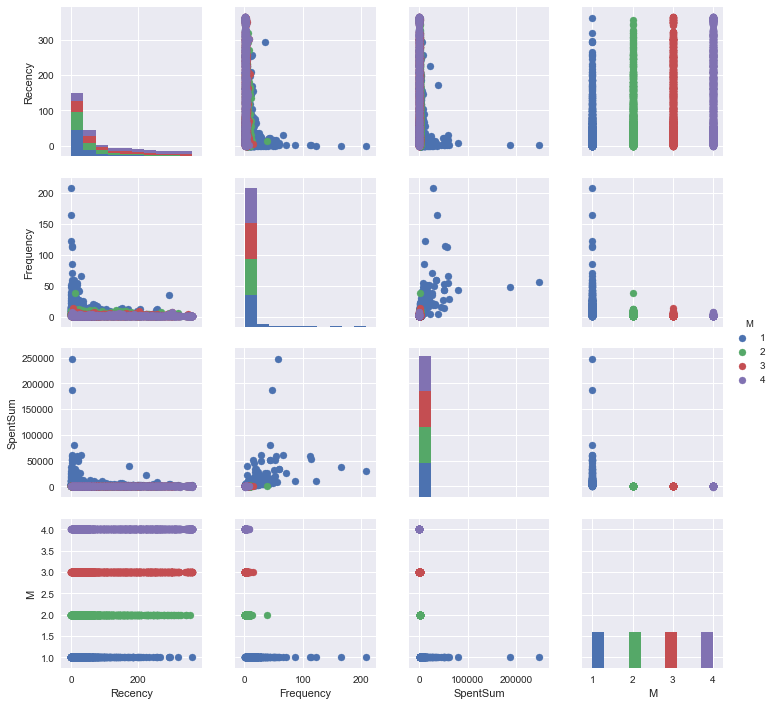

In [182]:
df = customerdb[['Recency', 'Frequency', 'SpentSum', 'M'] ]
g = sns.PairGrid(df, hue='M')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()